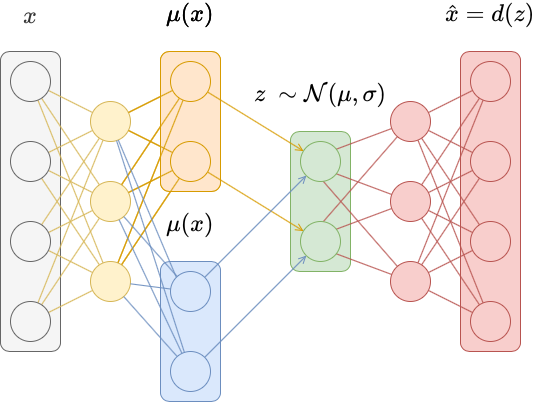

The basic idea of Variational autoecndoer (VAE) is to encode information not into a vector like usual autoecndoer, but into distibution of values, which are defined with two vector parameters: μ - center (mean) value of each distribution and σ - standard deviation (or logarithm of the standard deviation), which defines the spread (variance) of each element in the distribution.

In [4]:
import torch 
from torch import nn 
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset
from torch.optim import Adam 
from torchsummary import summary

import matplotlib.pyplot as plt 
from tqdm import tqdm

import os 
from PIL import Image

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
device

'cpu'

In [8]:
common_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop((128, 128)),
    transforms.ToTensor()
])

In [9]:
class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.data = sorted(os.listdir(self.data_path))
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img = os.path.join(self.data_path, self.data[idx])
        img = Image.open(img)

        if self.transform:
            img = self.transform(img)
    
        return img, img

In [10]:
data_link = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
dataset = CustomDataset(data_link, transform=common_transform)

In [11]:
x, y = dataset[0]
x.shape, y.shape

(torch.Size([3, 128, 128]), torch.Size([3, 128, 128]))

In [12]:
train_data, val_data, test_data= random_split(dataset, [0.8, 0.1, 0.1])

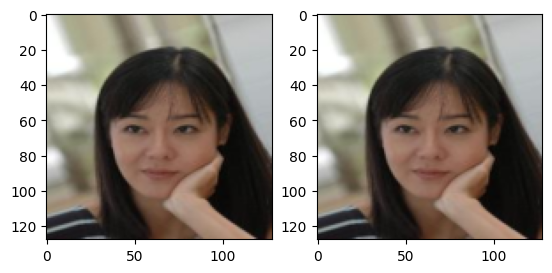

In [13]:
x, y = train_data[0]
x = x.permute(1, 2, 0)
y = y.permute(1, 2, 0)

plt.subplot(1, 2, 1)
plt.imshow(x)

plt.subplot(1, 2, 2)
plt.imshow(y)

plt.show()

In [14]:
def output(data, limit):
    for i, (x, y) in enumerate(data):
        x = x.permute(1, 2, 0).detach().cpu().numpy()
        y = y.permute(1, 2, 0).detach().cpu().numpy()
    
        plt.figure(figsize=(10, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(x)
        plt.title("Feature")
    
        plt.subplot(1, 2, 2)
        plt.imshow(y)
        plt.title("Label")
    
        plt.show()
    
        
        if i+1 >= limit:
            break
    

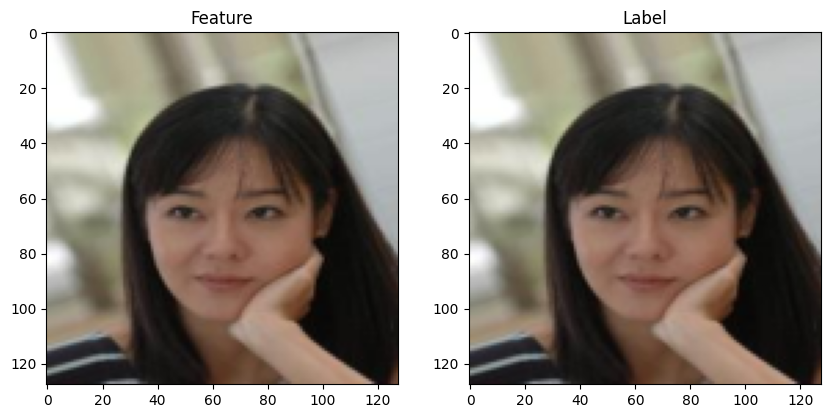

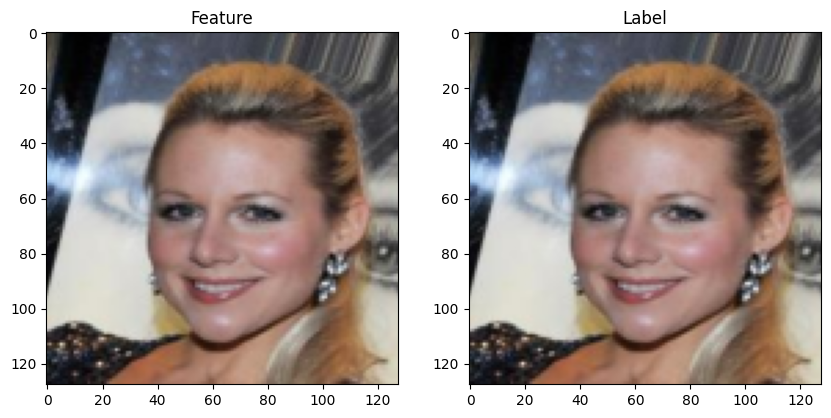

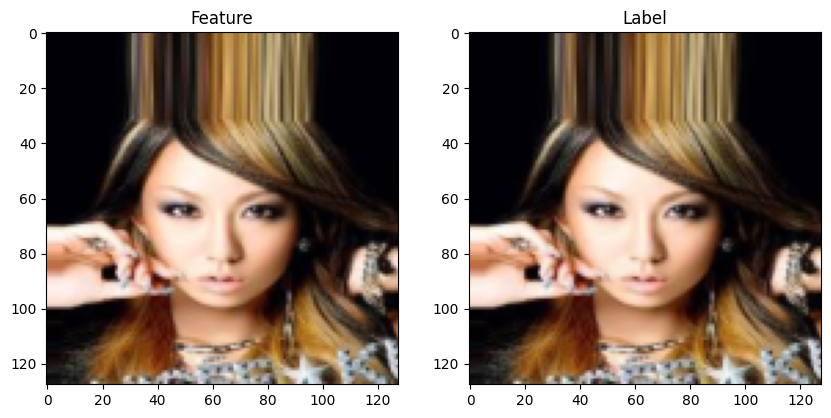

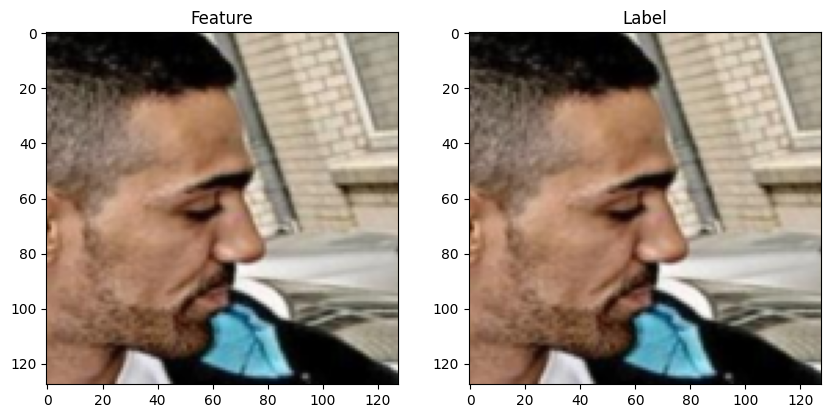

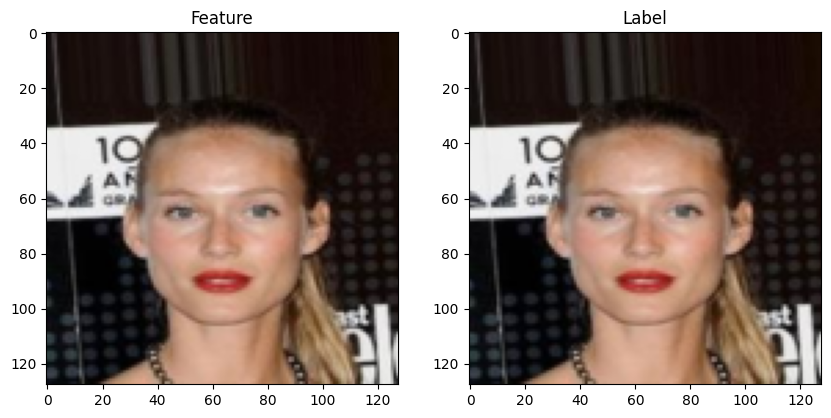

In [15]:
output(train_data, 5)

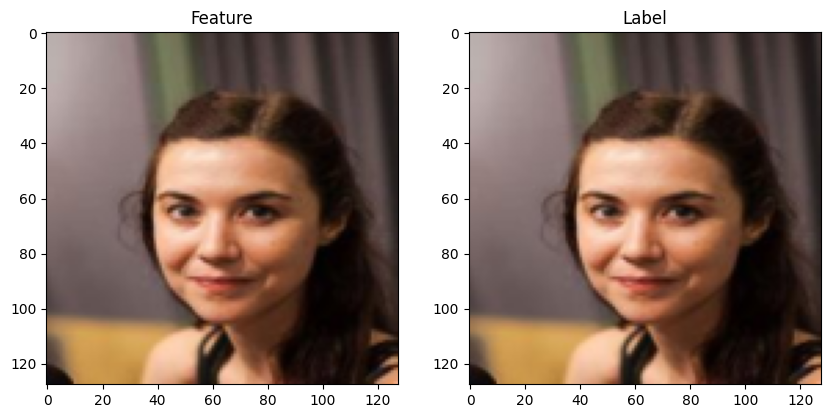

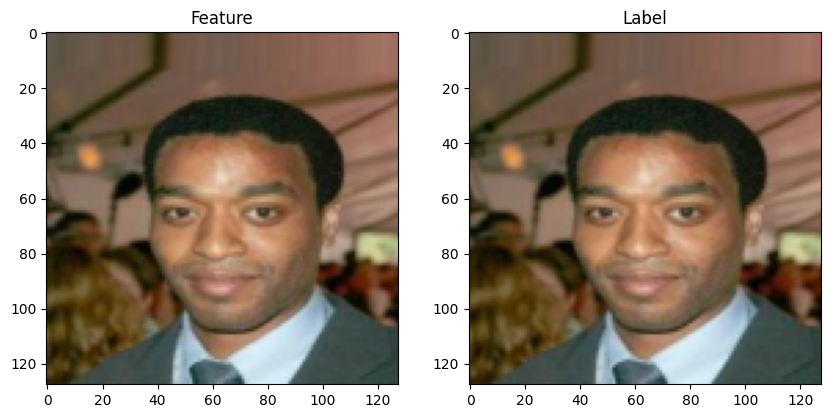

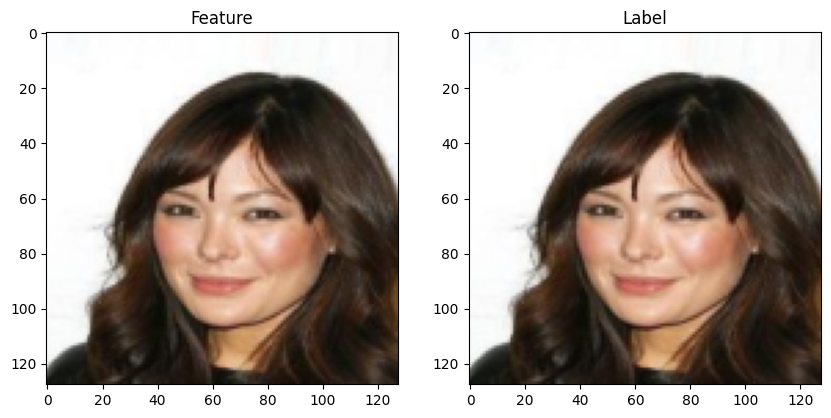

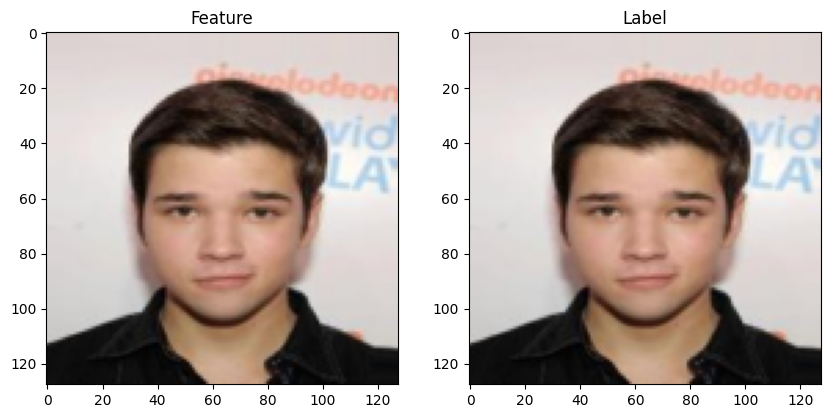

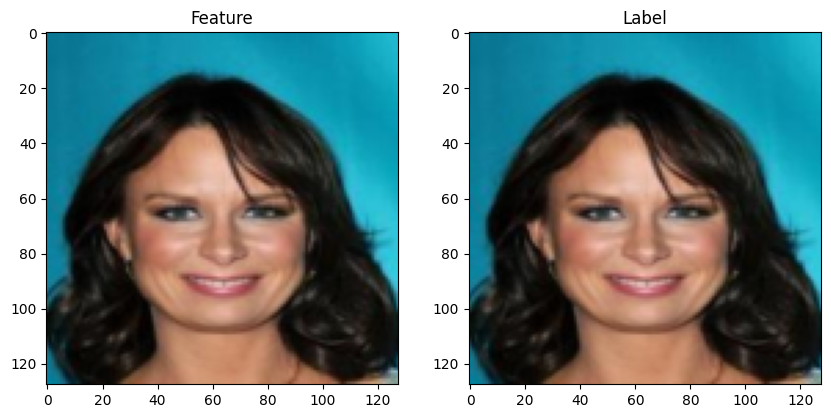

In [16]:
output(val_data, 5)

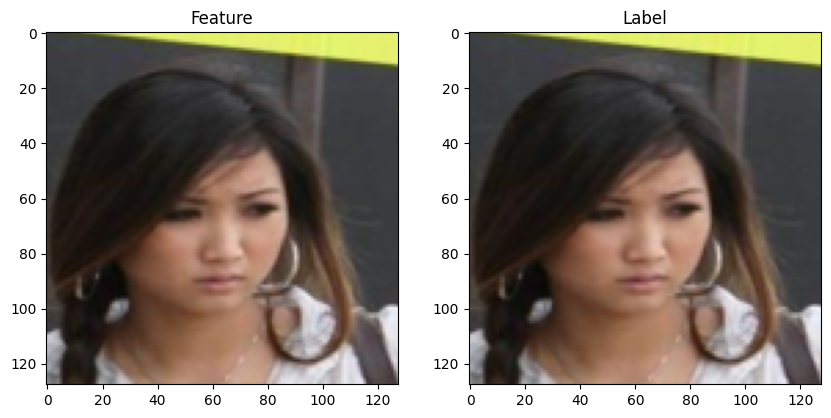

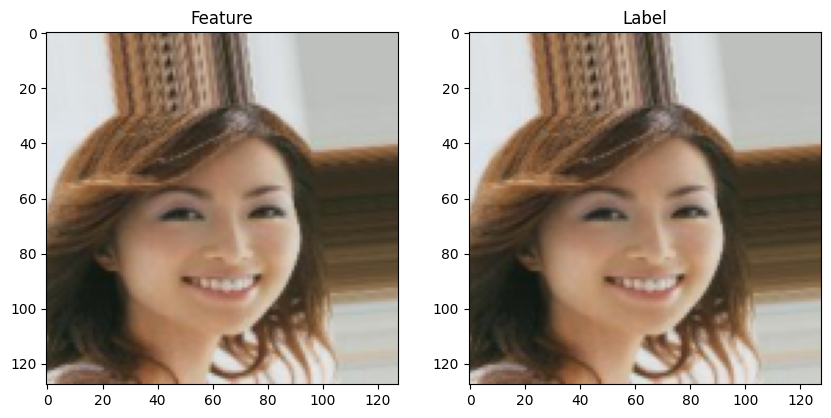

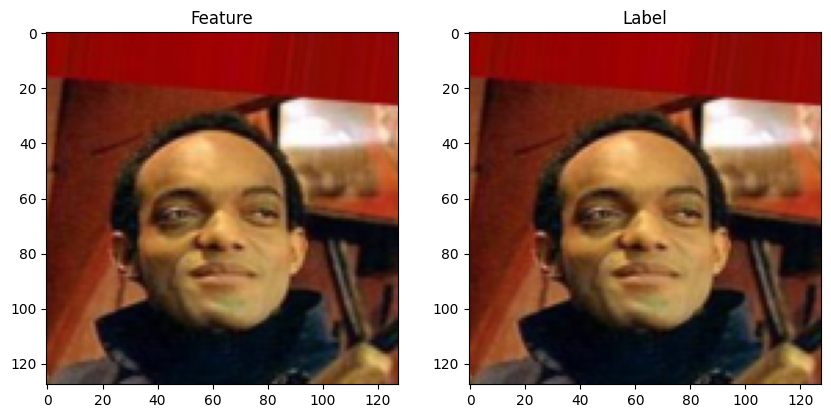

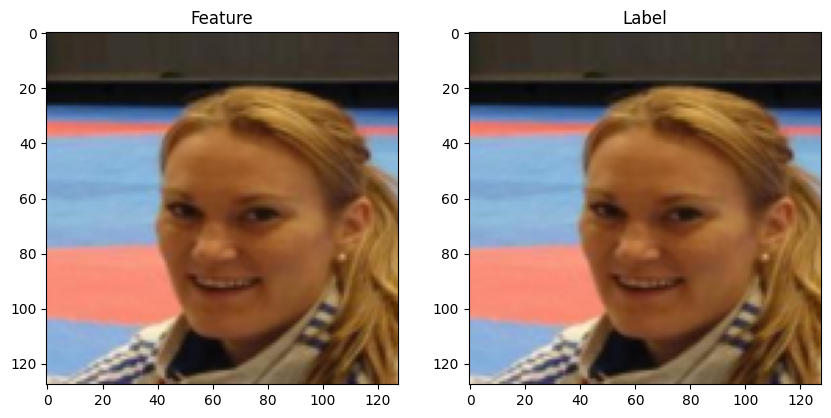

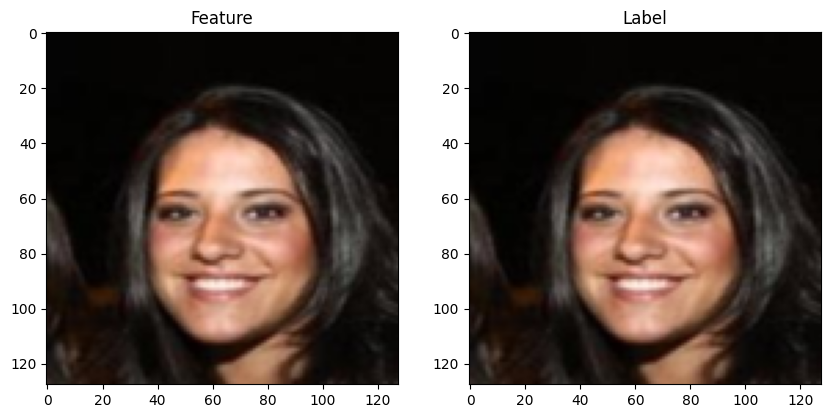

In [17]:
output(test_data, 5)

In [18]:
len(train_data), len(val_data), len(test_data)

(162080, 20260, 20259)

In [ ]:
# train_data, val_data, test_data, _ = random_split(train_data, [0.25, 0.035, 0.035, 0.68]) 

In [ ]:
# len(train_data), len(val_data), len(test_data)

In [19]:
batch_size = 32

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [20]:
x, y = next(iter(train_dl))
print(x.shape, y.shape)

torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128])


In [56]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        # 3, 128, 128
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.bnorm1 = nn.BatchNorm2d(32)
        # 32, 64, 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.bnorm2 = nn.BatchNorm2d(64)
        # 64, 32, 32
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bnorm3 = nn.BatchNorm2d(128)
        # 128, 16, 16
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.bnorm4 = nn.BatchNorm2d(256)
        # 256, 8, 8
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.bnorm5 = nn.BatchNorm2d(512)
        # 512, 4, 4
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(512*4*4, 1024)



        # ---------------------------------------------------------------------------------------------------------
        # this vector represents "centers" of hidden parameters - features, encoded to latent
        # layer:

        # in case of face generation:
        # μ = [0.1, 1.3, -1.2, ...]
        
        # 0.1 - could represent emotion on face
        # 1.3 - could represent how blond the hair (in context of face)
        # -1.2 - could represent how blue eyes (in context of face)
        # and etc.
        
        self.linear2_mu = nn.Linear(1024, latent_dim)



        
        # ---------------------------------------------------------------------------------------------------------
        # this vector contains variativity of distribution:

        # in case of face generation, where: 
        
        # μ = [0.1, 1.3, -1.2, ...],
        
        # variativity of hidden parameters could look like that
        # σ = [0.5, 1.2, 0.1, ...],

        # so 0.5, representing probability of emotions, show in which range emotion of face 
        # could be change

        # in the same way in works with variativity of blond hair (1.3 -> 1.2)
        # and variativity of blue eyes (-1.2 -> 0.1)

        
        self.linear2_logvar = nn.Linear(1024, latent_dim)

    def forward(self, x):
        out = F.leaky_relu(self.bnorm1(self.conv1(x)))
        # print(x.shape)
        out = F.leaky_relu(self.bnorm2(self.conv2(out)))
        out = F.leaky_relu(self.bnorm3(self.conv3(out)))
        out = F.leaky_relu(self.bnorm4(self.conv4(out)))
        out = F.leaky_relu(self.bnorm5(self.conv5(out)))
 
        out = self.flatten(out)
       
            
        h = F.leaky_relu(self.linear1(out))
        # h = F.leaky_relu(self.linear2(out))
        
        mu = self.linear2_mu(h)
        logvar = self.linear2_logvar(h)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()

        self.linear1 = nn.Linear(latent_dim, 1024)
        self.linear2 = nn.Linear(1024, 512*4*4)
        # x.view(256, 7, 7)
        self.unflatten = nn.Unflatten(1, (512, 4, 4))
        
        # 512, 4, 4
        self.t_conv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.bnorm1 = nn.BatchNorm2d(256)
        # 256, 8, 8
        self.t_conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.bnorm2 = nn.BatchNorm2d(128)
        # 128, 16, 16
        self.t_conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bnorm3 = nn.BatchNorm2d(64)
        # 64, 32, 32
        self.t_conv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2,  padding=1)
        self.bnorm4 = nn.BatchNorm2d(32)
        # 32, 64, 64
        self.t_conv5 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)
        # 3, 128, 128

    
        # self.upsmaple1 = nn.Upsample(scale_factor=2, mode='bilinear')


    def forward(self, x):
        # print(x.shape)
        out = F.leaky_relu(self.linear1(x))
        # print(out.shape)
        out = F.leaky_relu(self.linear2(out))
        # print(out.shape)
        # out = F.leaky_relu(self.linear3(out))
        # print(out.shape)
        # out = out.view(-1, 512, 3, 3)
        out = self.unflatten(out)
        # print(out.shape)
        # out = F.leaky_relu(self.bnorm0(self.t_conv0(out)))
        # print(out.shape)
        out = F.leaky_relu(self.bnorm1(self.t_conv1(out)))
        # print(out.shape)
        out = F.leaky_relu(self.bnorm2(self.t_conv2(out)))
        # print(out.shape)
        out = F.leaky_relu(self.bnorm3(self.t_conv3(out)))
        # print(out.shape)
        out = F.leaky_relu(self.bnorm4(self.t_conv4(out)))
        # print(out.shape)
        # rec = F.tanh(self.t_conv5(out))
        rec = F.sigmoid(self.t_conv5(out))
       
        return rec


class VAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    # implementation of reparameterization trick
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.rand_like(std)
        # z = μ+σ*ε
        z = mu + std * eps
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        rec = self.decoder(z)
        return rec, mu, logvar

    def predict(self, x):
        self.eval()

        with torch.no_grad():
            if len(x.shape) == 4:
                out, _, _ = self.forward(x)
            elif len(x.shape) < 4:
                x = x.unsqueeze(0)
                out, _, _ = self.forward(x)
                
            out = out.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
            
            
        return out

    def sample(self, z):
        self.eval()

        with torch.no_grad():
            out = self.decoder(z)
        out = out.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        return out
        
            

The role of KL-divergention in VAE learning is important and it's task is to make generated distribution q(z|x) look as much as possible like standart normal distribution N(0, I).

In [22]:
def loss_function(recon_x, x, mu, logvar, kl_weight=0.1):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')  # or BCE, if normilized in range [0,1]
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL-divergention
    return recon_loss + kl_loss * kl_weight


In [57]:
model = VAE()
model.to(device)

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bnorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bnorm5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=8192, out_features=

In [24]:
tensor = torch.rand(1, 3, 128, 128).to(device)
res, _, _ = model(tensor)
res.shape

torch.Size([1, 3, 128, 128])

In [20]:
tensor = torch.rand(1, 3, 128, 128).to(device)
res = model.predict(tensor)
res.shape

(128, 128, 3)

Text(0.5, 1.0, 'Output, (128, 128, 3)')

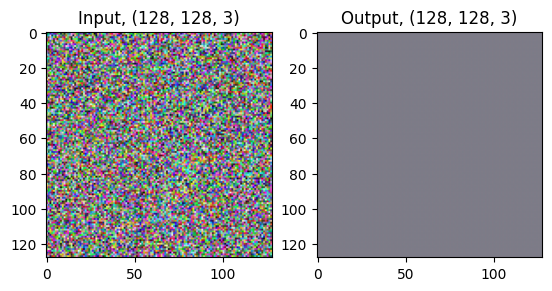

In [21]:
tensor = torch.rand(1, 3, 128, 128).to(device)
t_tensor = tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

res = model.predict(tensor)

res_shape = res.shape
t_tensor_shape = t_tensor.shape

plt.subplot(1, 2, 1)
plt.imshow(t_tensor)
plt.title(f"Input, {t_tensor_shape}")

plt.subplot(1, 2, 2)
plt.imshow(res)
plt.title(f"Output, {res_shape}")

In [22]:
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,568
       BatchNorm2d-2           [-1, 32, 64, 64]              64
            Conv2d-3           [-1, 64, 32, 32]          32,832
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5          [-1, 128, 16, 16]         131,200
       BatchNorm2d-6          [-1, 128, 16, 16]             256
            Conv2d-7            [-1, 256, 8, 8]         524,544
       BatchNorm2d-8            [-1, 256, 8, 8]             512
            Conv2d-9            [-1, 512, 4, 4]       2,097,664
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
          Flatten-11                 [-1, 8192]               0
           Linear-12                 [-1, 1024]       8,389,632
           Linear-13                  [-1, 256]         262,400
           Linear-14                  [

In [51]:
optimizer = Adam(model.parameters(), lr=1e-3)

In [103]:
def train(model, train_dl, val_dl, loss_fn, optimizer, epochs, device):
    history = {
        "train_loss": [],
        "val_loss": []
    }

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for x, y in tqdm(train_dl):
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            pred, mu, log_var = model(x)
            
            loss = loss_fn(pred, y, mu, log_var)
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        total_train_loss = train_loss / len(train_dl)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in tqdm(val_dl):
                x = x.to(device)
                y = y.to(device)
                
                pred, mu, log_var = model(x)
                loss = loss_fn(pred, y, mu, log_var)
                val_loss += loss.item()


        total_val_loss = val_loss / len(val_dl)

        history["train_loss"].append(total_train_loss)
        history["val_loss"].append(total_val_loss)

        print(
            f"Epoch: {epoch+1}; "
            f"train_loss: {total_train_loss:.4f}; "
            f"val_loss: {total_val_loss:.4f}"
        )

    return history           
        

In [104]:
history = train(model, train_dl, val_dl, loss_function, optimizer, 40, device)

100%|██████████| 634/634 [01:03<00:00, 10.06it/s]


Epoch: 1; train_loss: 49413.9394; val_loss: 36520.5595


100%|██████████| 634/634 [00:42<00:00, 14.95it/s]


Epoch: 2; train_loss: 33478.9652; val_loss: 31254.1668


100%|██████████| 634/634 [00:41<00:00, 15.12it/s]


Epoch: 3; train_loss: 28959.0154; val_loss: 28032.1803


100%|██████████| 634/634 [00:43<00:00, 14.73it/s]


Epoch: 4; train_loss: 26627.1096; val_loss: 26137.3103


100%|██████████| 634/634 [00:41<00:00, 15.18it/s]


Epoch: 5; train_loss: 25061.1016; val_loss: 25508.9475


100%|██████████| 634/634 [00:43<00:00, 14.72it/s]


Epoch: 6; train_loss: 23958.8143; val_loss: 25190.2800


100%|██████████| 634/634 [00:44<00:00, 14.13it/s]


Epoch: 7; train_loss: 23221.4365; val_loss: 24044.8231


100%|██████████| 634/634 [00:45<00:00, 14.07it/s]


Epoch: 8; train_loss: 22423.8044; val_loss: 23796.4594


100%|██████████| 634/634 [00:42<00:00, 14.94it/s]


Epoch: 9; train_loss: 21785.4018; val_loss: 23768.6758


100%|██████████| 634/634 [00:43<00:00, 14.41it/s]


Epoch: 10; train_loss: 21203.2105; val_loss: 23511.3741


100%|██████████| 634/634 [00:41<00:00, 15.11it/s]


Epoch: 11; train_loss: 20843.6235; val_loss: 23059.4257


100%|██████████| 634/634 [00:43<00:00, 14.55it/s]


Epoch: 12; train_loss: 20302.4909; val_loss: 22579.6405


100%|██████████| 634/634 [00:42<00:00, 14.89it/s]


Epoch: 13; train_loss: 19778.2770; val_loss: 22838.7859


100%|██████████| 634/634 [00:42<00:00, 14.76it/s]


Epoch: 14; train_loss: 19443.3275; val_loss: 21594.6189


100%|██████████| 634/634 [00:44<00:00, 14.23it/s]


Epoch: 15; train_loss: 19285.4862; val_loss: 21857.7439


100%|██████████| 634/634 [00:43<00:00, 14.67it/s]


Epoch: 16; train_loss: 18885.1558; val_loss: 21741.2458


100%|██████████| 634/634 [00:44<00:00, 14.38it/s]


Epoch: 17; train_loss: 18623.6417; val_loss: 21291.3831


100%|██████████| 634/634 [00:43<00:00, 14.62it/s]


Epoch: 18; train_loss: 18329.0648; val_loss: 21688.0025


100%|██████████| 634/634 [00:42<00:00, 15.02it/s]


Epoch: 19; train_loss: 18058.1730; val_loss: 21966.7682


100%|██████████| 634/634 [00:42<00:00, 14.95it/s]


Epoch: 20; train_loss: 17786.7242; val_loss: 21928.8196


100%|██████████| 634/634 [00:42<00:00, 14.93it/s]


Epoch: 21; train_loss: 17584.5639; val_loss: 21786.3592


100%|██████████| 634/634 [00:41<00:00, 15.39it/s]


Epoch: 22; train_loss: 17378.6700; val_loss: 22094.3214


100%|██████████| 634/634 [00:42<00:00, 14.90it/s]


Epoch: 23; train_loss: 17146.6079; val_loss: 22228.6789


100%|██████████| 634/634 [00:42<00:00, 14.94it/s]


Epoch: 24; train_loss: 16882.0742; val_loss: 22578.1832


100%|██████████| 634/634 [00:43<00:00, 14.58it/s]


Epoch: 25; train_loss: 16504.1088; val_loss: 22339.7390


100%|██████████| 634/634 [00:43<00:00, 14.50it/s]


Epoch: 26; train_loss: 16075.7375; val_loss: 22174.9486


100%|██████████| 634/634 [00:41<00:00, 15.22it/s]


Epoch: 27; train_loss: 15852.2846; val_loss: 22300.5943


100%|██████████| 634/634 [00:41<00:00, 15.15it/s]


Epoch: 28; train_loss: 15675.8853; val_loss: 21719.3629


100%|██████████| 634/634 [00:41<00:00, 15.21it/s]


Epoch: 29; train_loss: 15534.7906; val_loss: 22286.5865


100%|██████████| 634/634 [00:41<00:00, 15.20it/s]


Epoch: 30; train_loss: 15324.4495; val_loss: 22258.3982


100%|██████████| 634/634 [00:41<00:00, 15.24it/s]


Epoch: 31; train_loss: 15081.0600; val_loss: 22007.2208


100%|██████████| 634/634 [00:42<00:00, 15.09it/s]


Epoch: 32; train_loss: 14867.1220; val_loss: 22258.7465


100%|██████████| 634/634 [00:41<00:00, 15.24it/s]


Epoch: 33; train_loss: 14638.6228; val_loss: 22991.8835


100%|██████████| 634/634 [00:41<00:00, 15.29it/s]


Epoch: 34; train_loss: 14553.3853; val_loss: 22990.1821


100%|██████████| 634/634 [00:42<00:00, 15.06it/s]


Epoch: 35; train_loss: 14465.7461; val_loss: 22473.8410


100%|██████████| 634/634 [00:42<00:00, 14.83it/s]


Epoch: 36; train_loss: 14232.9390; val_loss: 22558.3875


100%|██████████| 634/634 [00:40<00:00, 15.46it/s]


Epoch: 37; train_loss: 14065.0732; val_loss: 22761.0436


100%|██████████| 634/634 [00:42<00:00, 14.95it/s]


Epoch: 38; train_loss: 13832.5924; val_loss: 22677.7374


100%|██████████| 634/634 [00:42<00:00, 15.04it/s]


Epoch: 39; train_loss: 13613.9631; val_loss: 22879.7386


100%|██████████| 634/634 [00:41<00:00, 15.16it/s]

Epoch: 40; train_loss: 13446.0239; val_loss: 23424.6373


In [26]:
device

'cpu'

In [62]:
model_link = "/kaggle/input/vae-weights/face_generator_VAE_02.pt"
model.load_state_dict(torch.load(model_link, map_location='cpu'))
model.to(device)

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bnorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bnorm5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=8192, out_features=

In [31]:
def output_results(data, limit):
    for i, (img, _) in enumerate(data):
        img = img.to(device)
        t_img = img.permute(1, 2, 0).cpu().numpy()
        
        plt.subplot(1, 2, 1)
        plt.imshow(t_img)
        plt.title("Original")
        
        res = model.predict(img)
        # res = res.squeeze(0)
        # res = res.permute(1, 2, 0).detach().cpu().numpy()
        plt.subplot(1, 2, 2)
        plt.imshow(res)
        plt.title("Generated")
    
        plt.show()
    
        if i+1 >= limit:
            break 




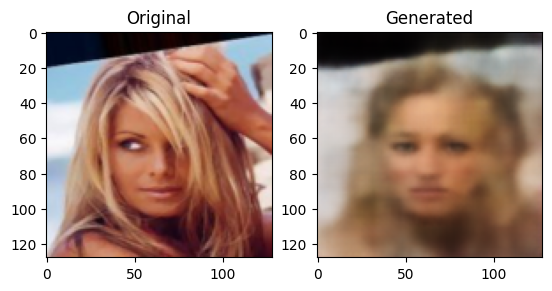

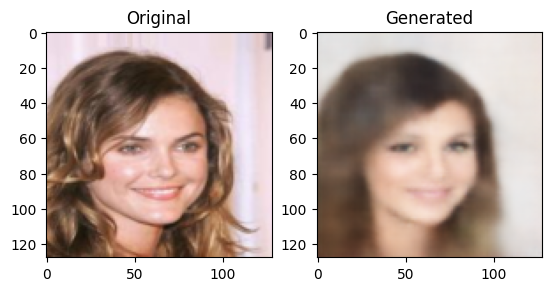

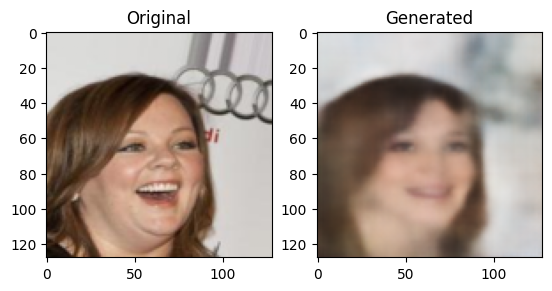

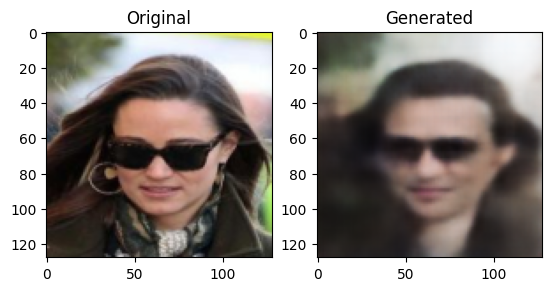

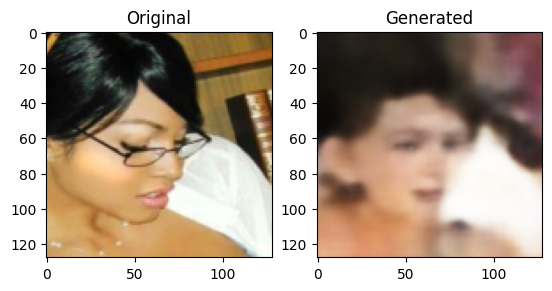

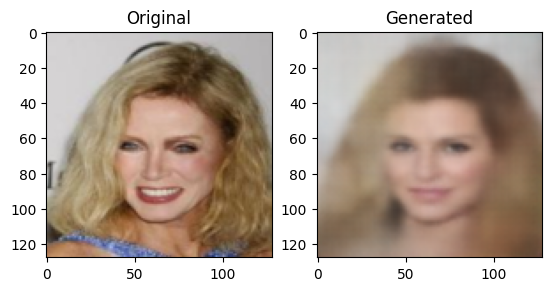

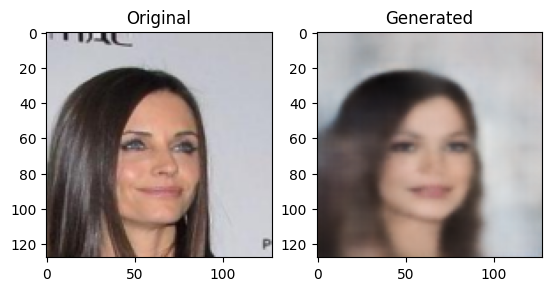

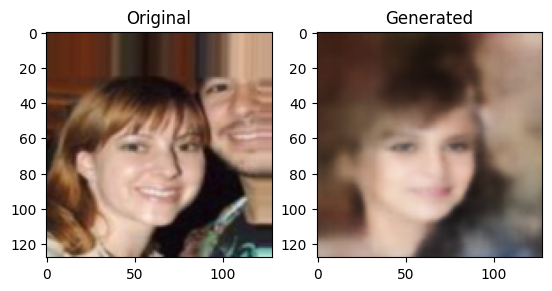

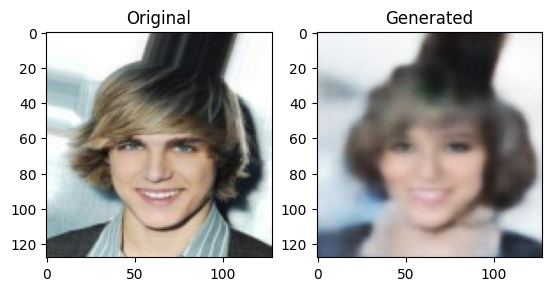

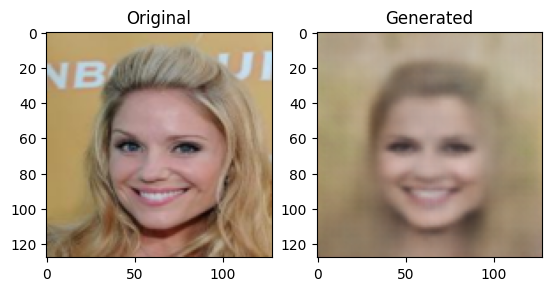

In [32]:
output_results(test_data, 10)

In [58]:
torch.save(model.state_dict(), "face_generator_VAE_02.pt")

In [107]:
def output_losses(history):
    plt.plot(history["train_loss"], label="train losses")
    plt.plot(history["val_loss"], label="validation losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.legend()
    plt.show()

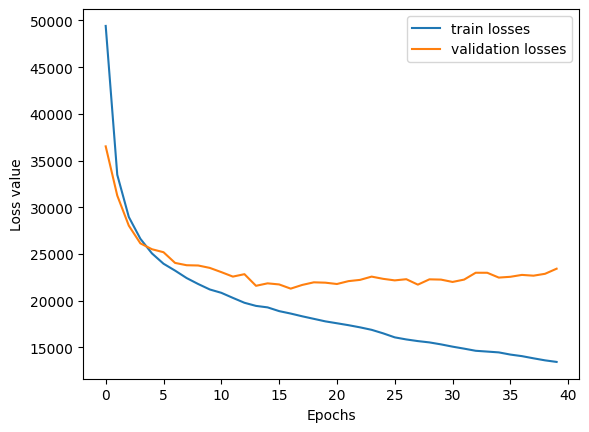

In [108]:
output_losses(history)

In [48]:
def original_face(link, transform):
    img = Image.open(link)
    if transform:
        img = transform(img)
    
    img = img.unsqueeze(0)
    
    return img

In [49]:
import math

def display_generations(face, limit=1):
    with torch.no_grad():
        mu, logvar = model.encoder(face)

        face = face.squeeze(0).permute(1, 2, 0).cpu().numpy()

        rows = math.ceil((limit + 1) / 5)  
        cols = 5  

        plt.figure(figsize=(30, 24))  
        
        plt.subplot(rows, cols, 1)
        plt.imshow(face)
        plt.axis("off")
        plt.title("Original")

        for i in range(limit):
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + std * eps

            variation = model.decoder(z)
            variation = variation.squeeze(0).permute(1, 2, 0).cpu().numpy()

            plt.subplot(rows, cols, i + 2)  
            plt.imshow(variation)
            plt.axis("off")
            plt.title(f"Variation {i+1}")

        plt.show()


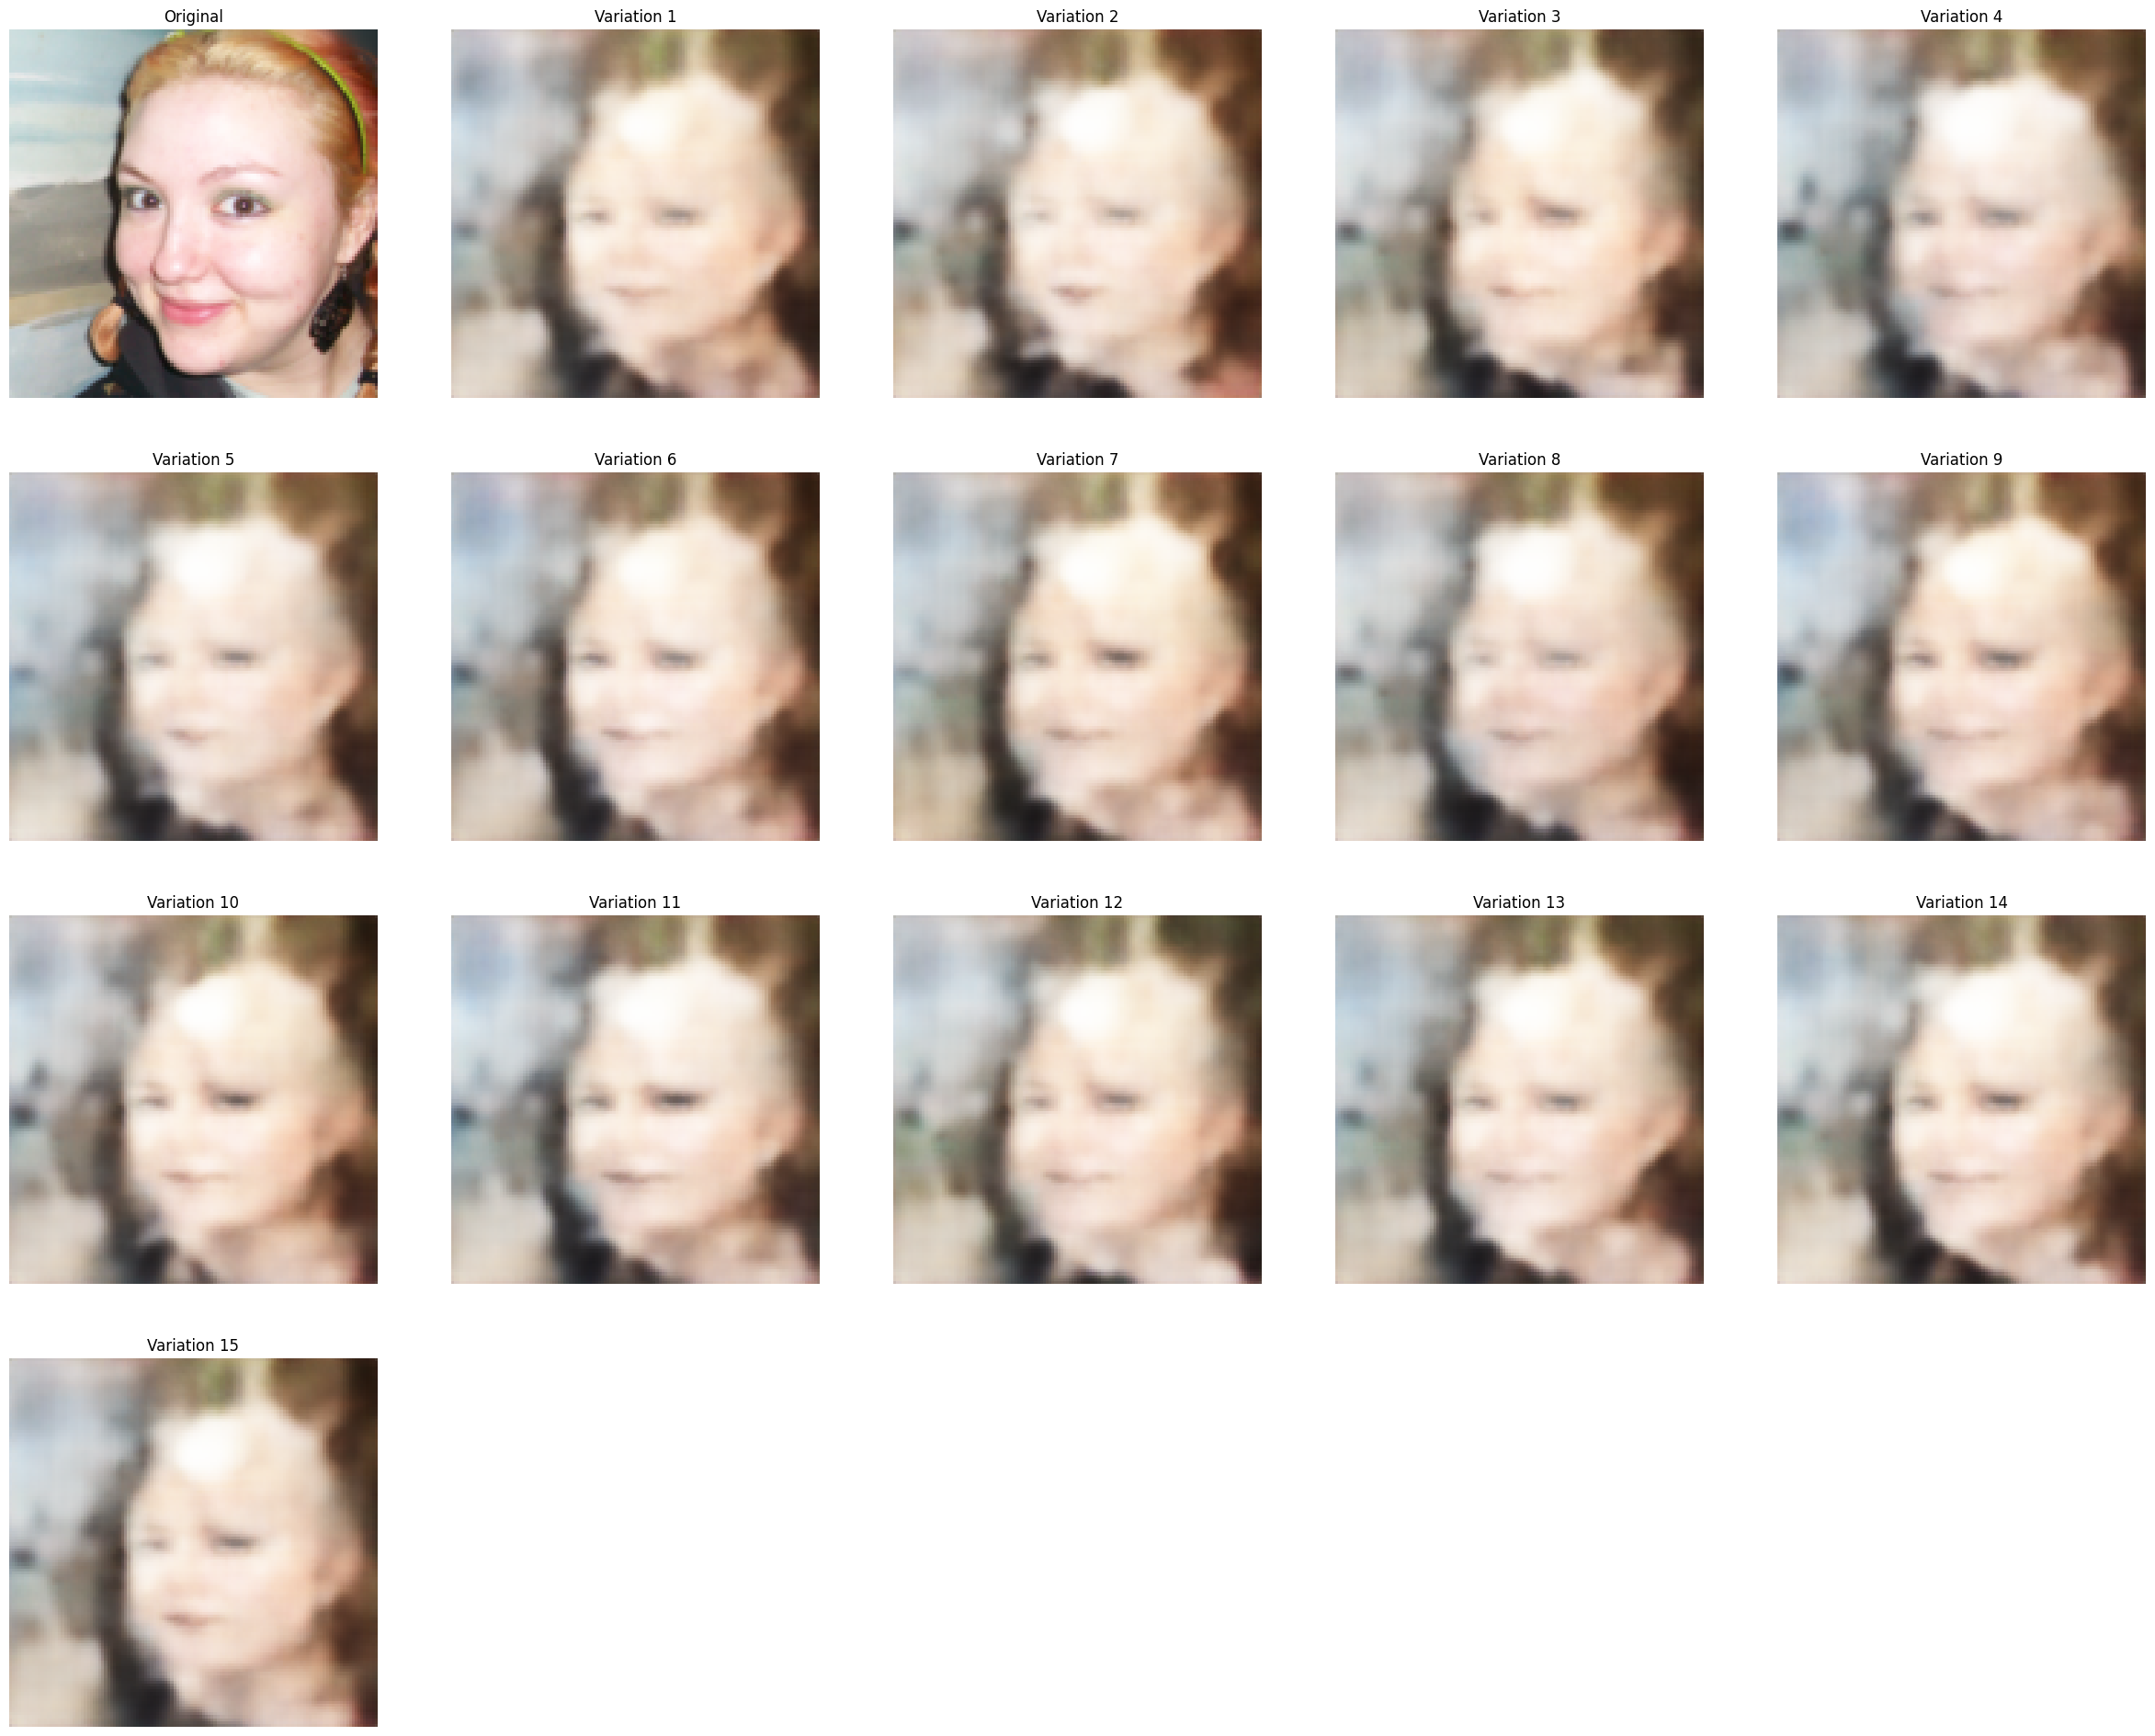

In [50]:
link = "/kaggle/input/flickrfaceshq-dataset-ffhq/00006.png"
face =  original_face(link, common_transform)
face = face.to(device)
display_generations(face, 15)

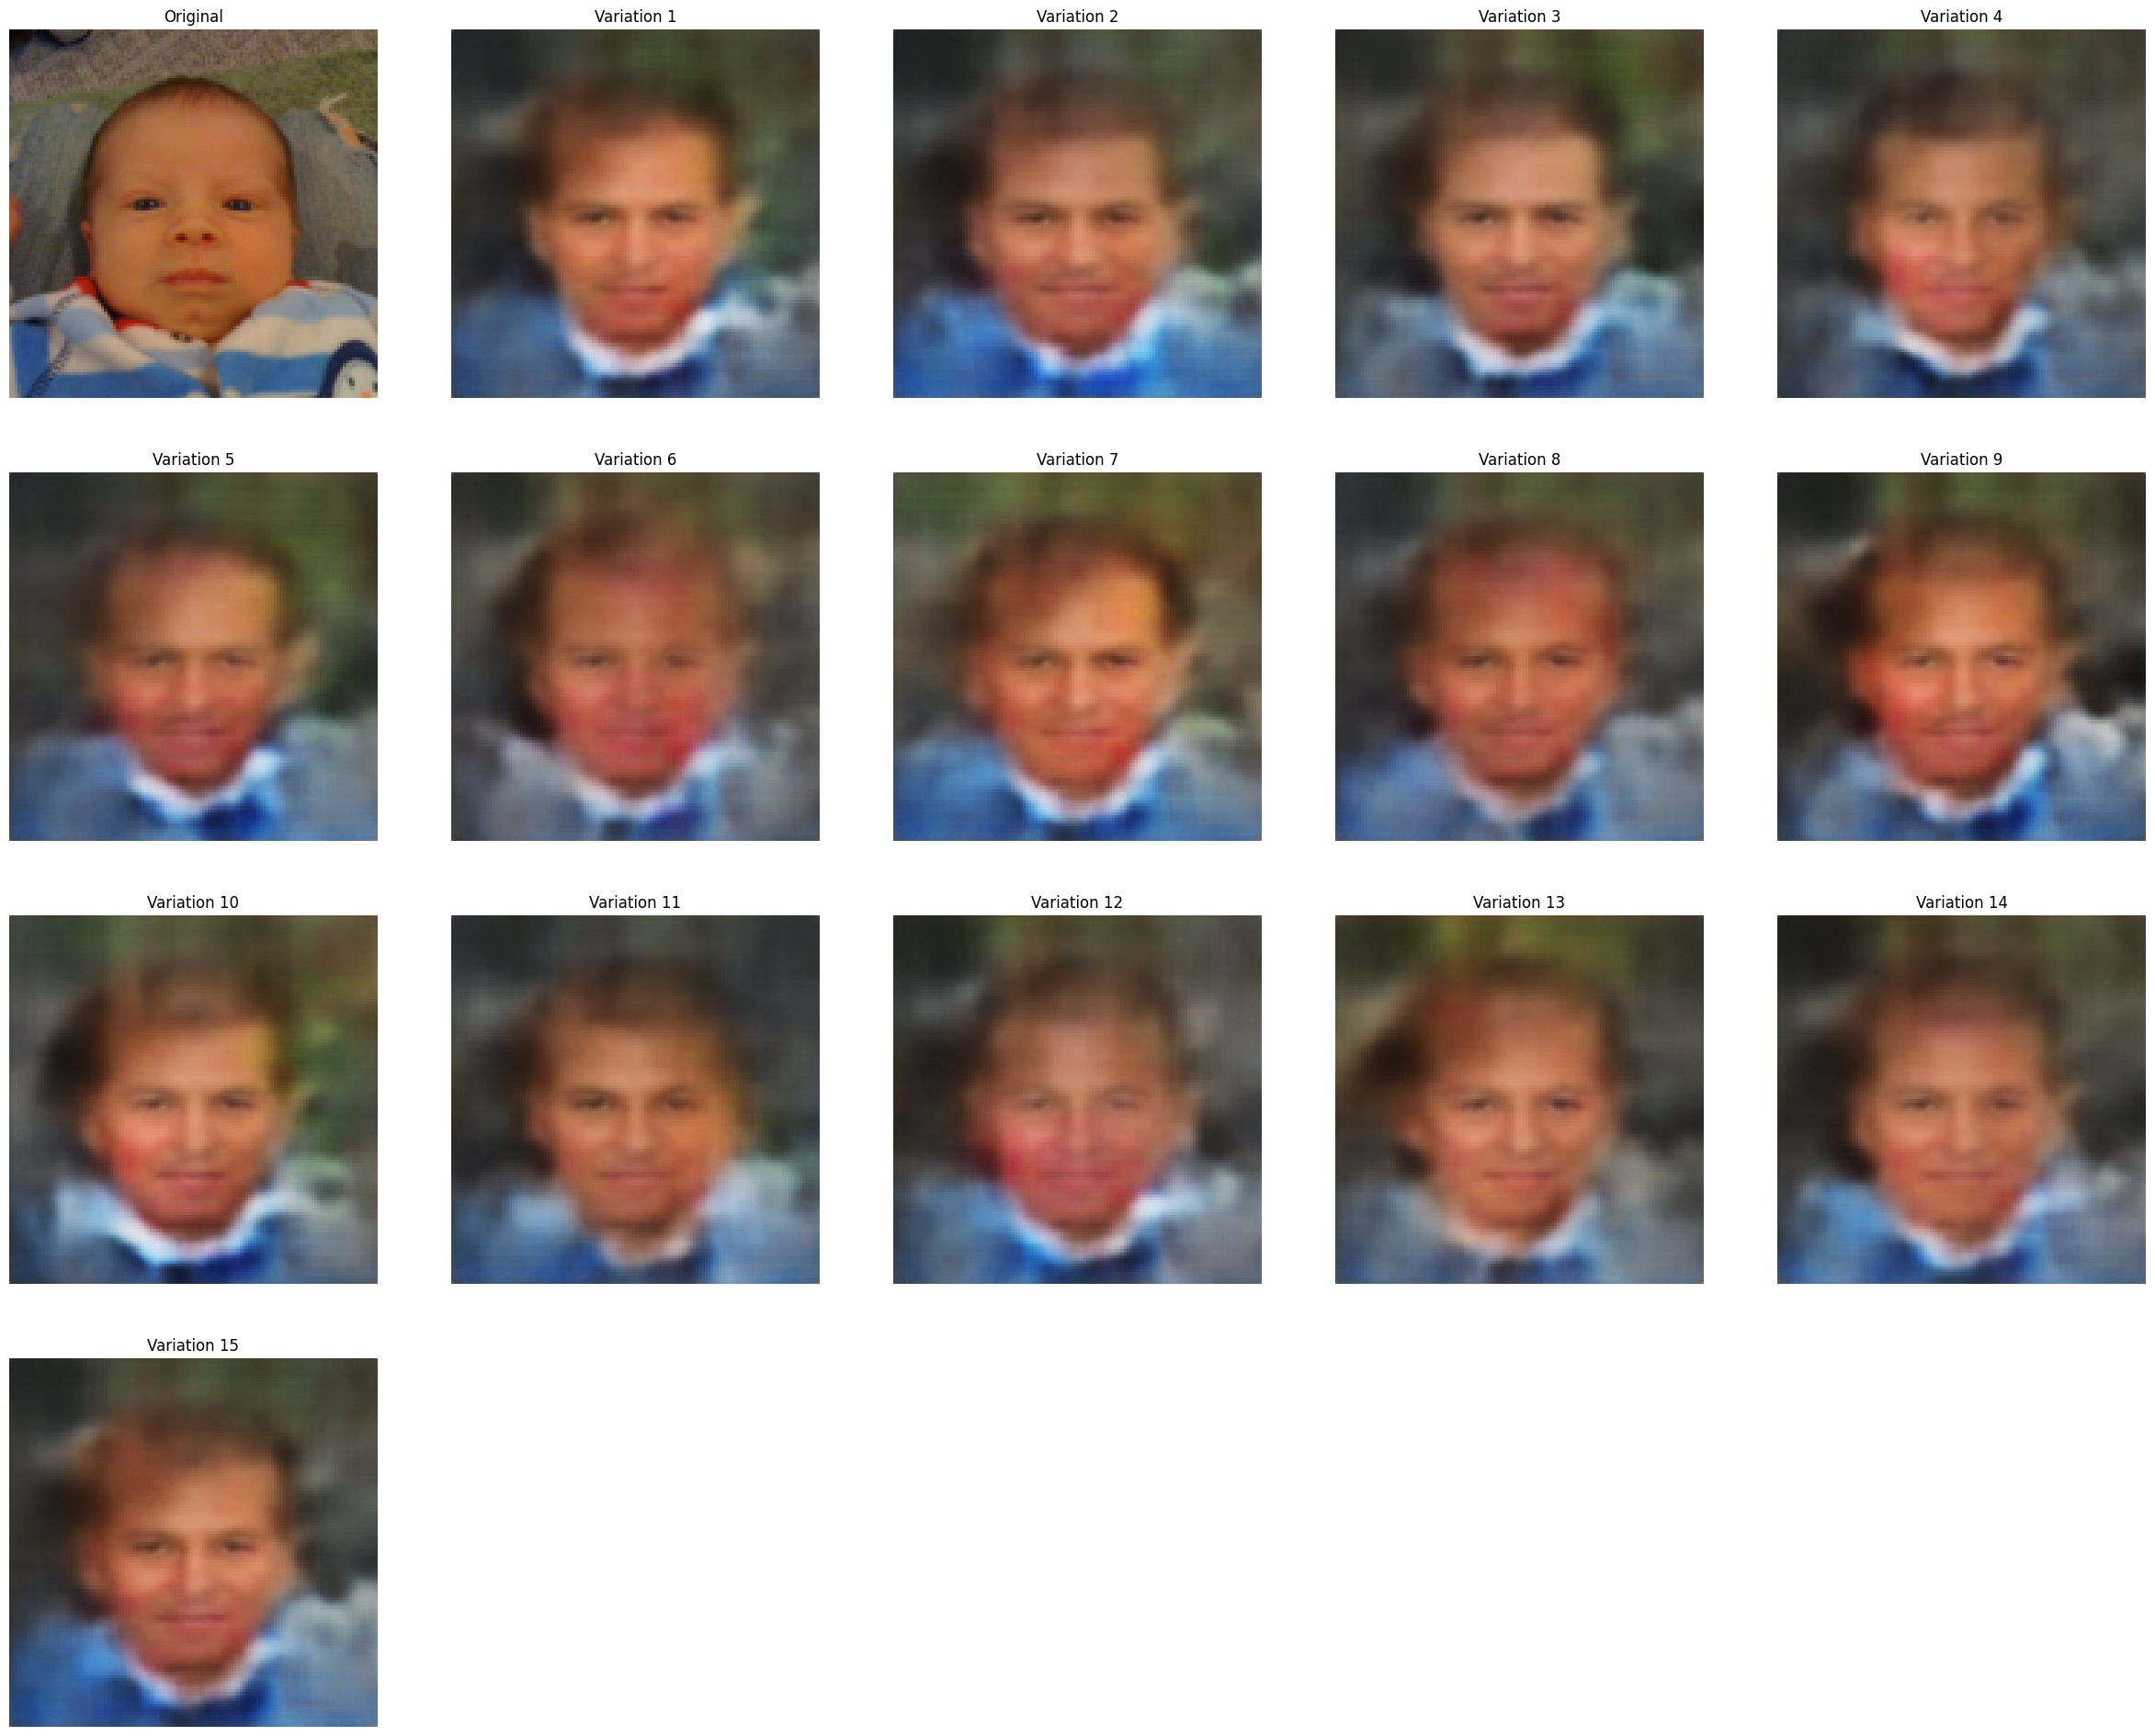

In [40]:
link = "/kaggle/input/flickrfaceshq-dataset-ffhq/00026.png"
face =  original_face(link, common_transform)
face = face.to(device)
display_generations(face, 15)

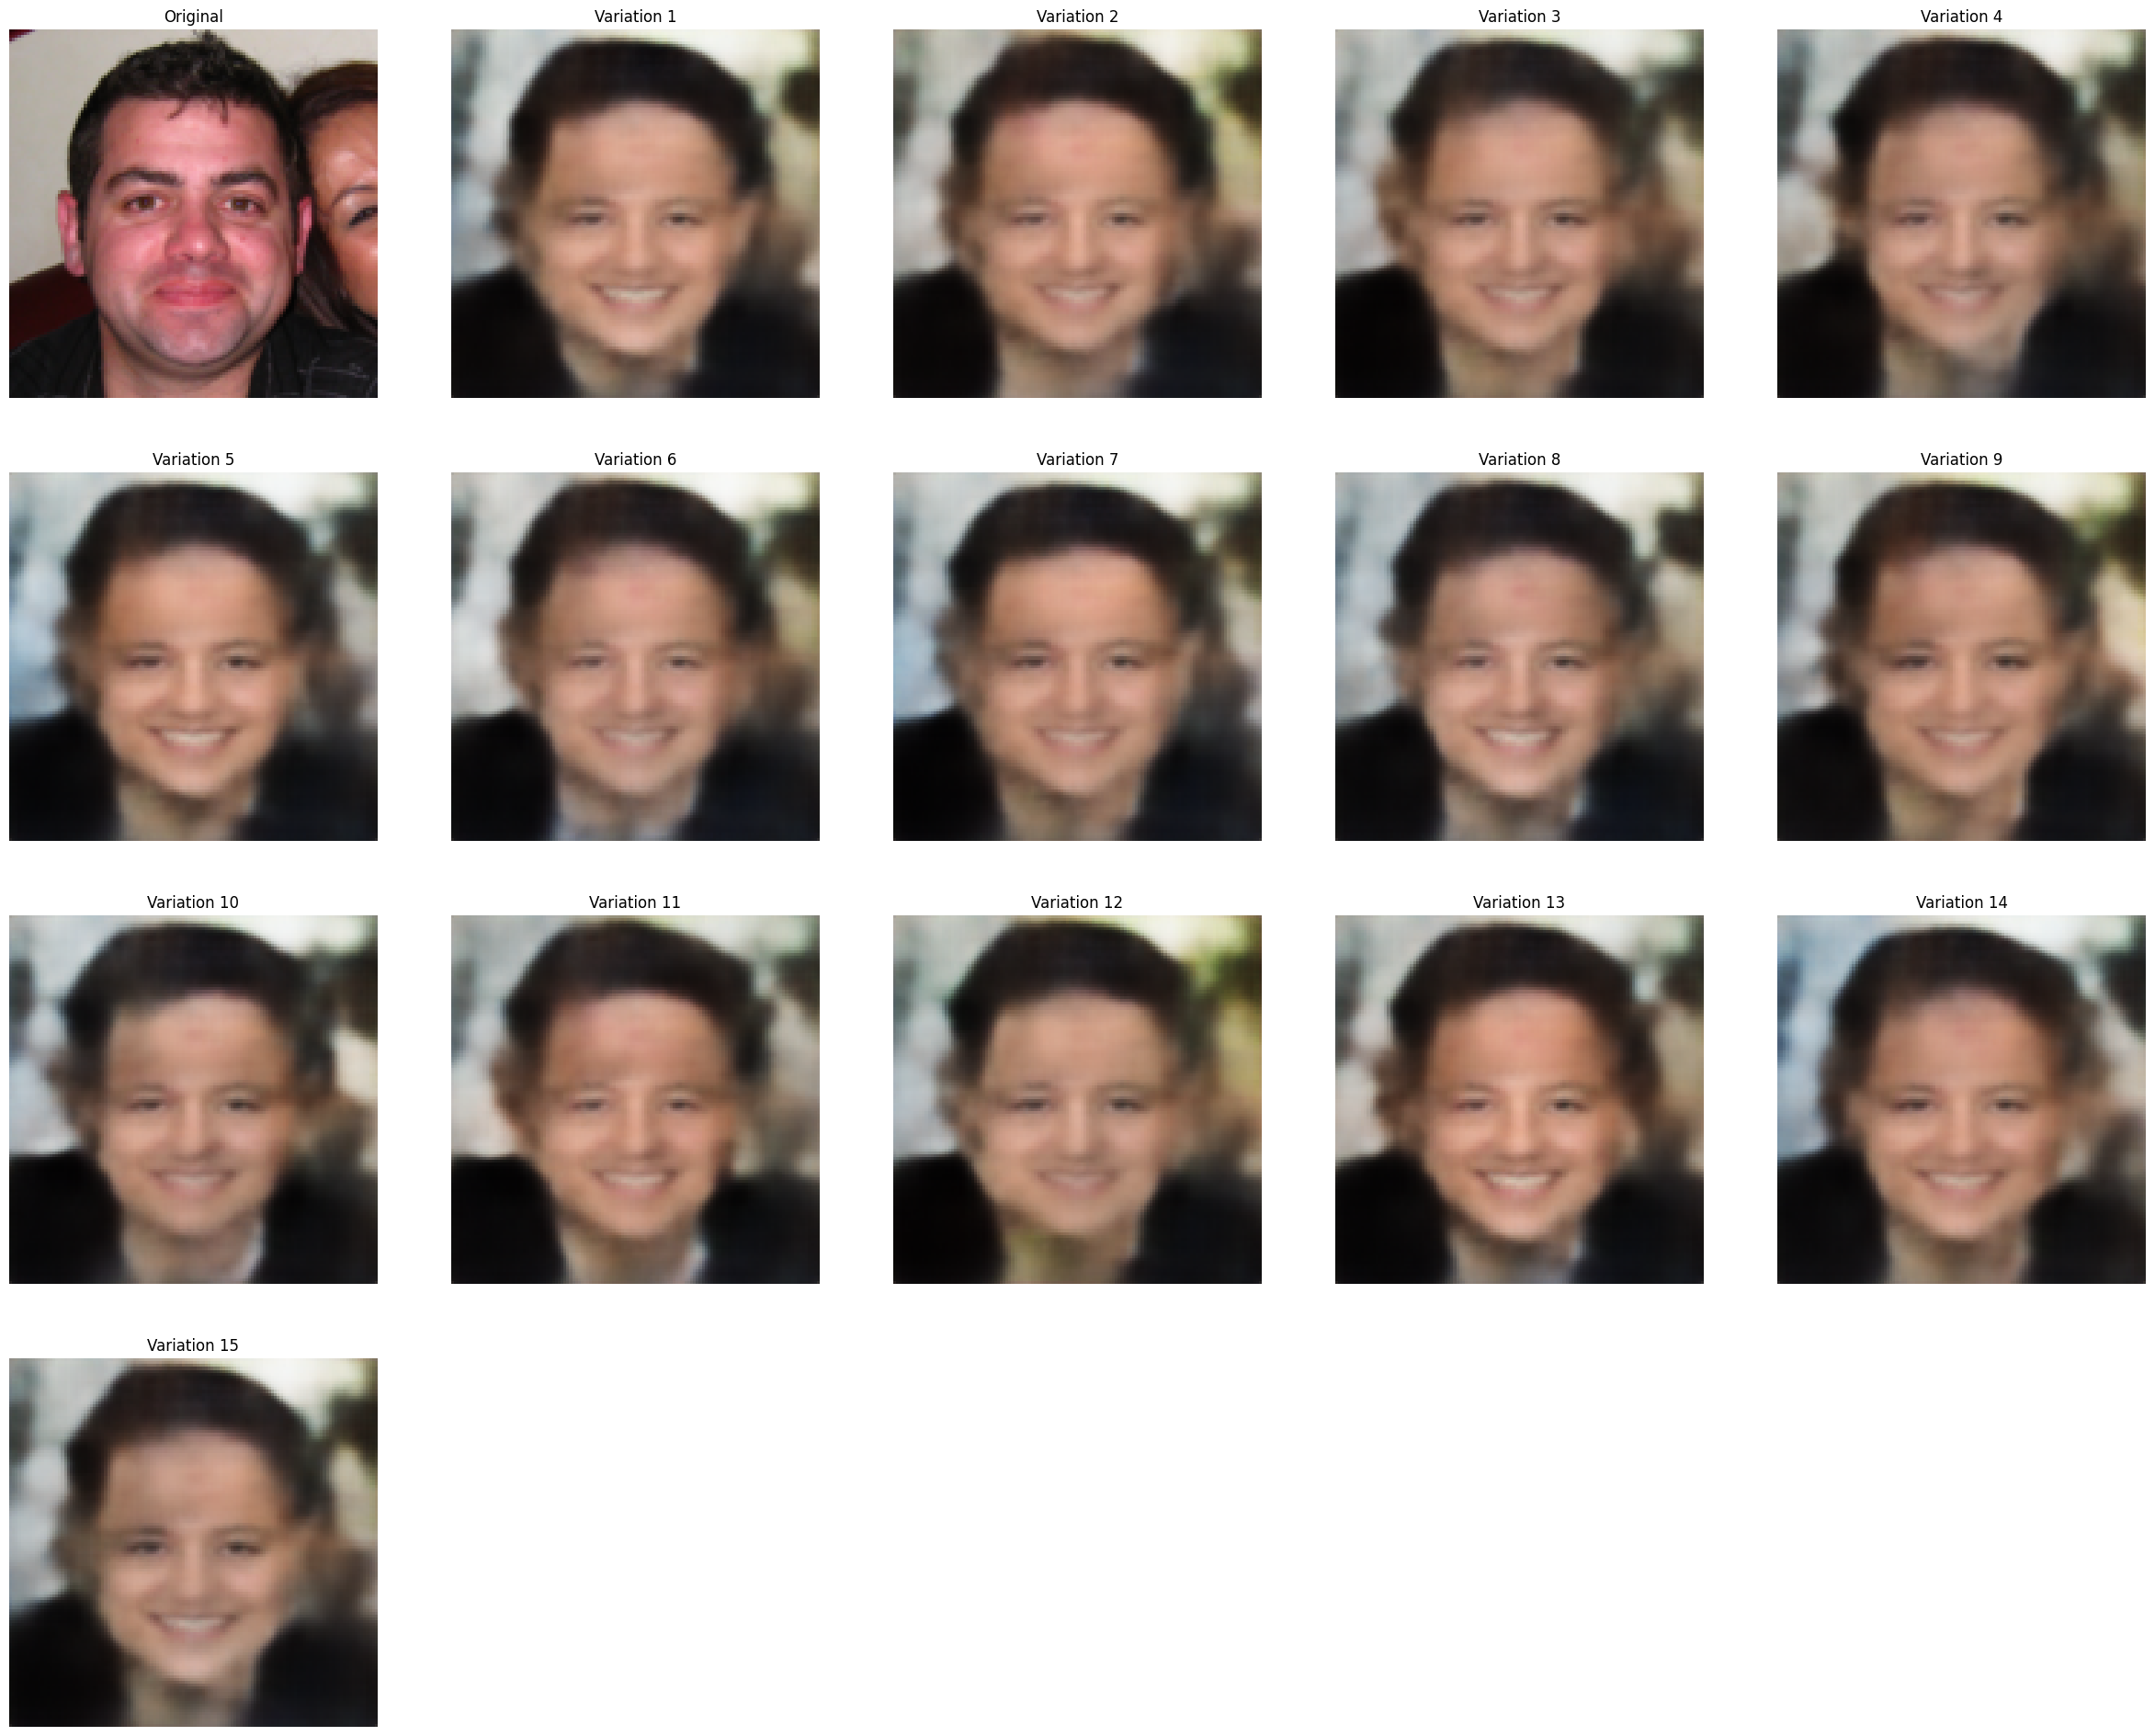

In [118]:
link = "/kaggle/input/flickrfaceshq-dataset-ffhq/00016.png"
face =  original_face(link, common_transform)
face = face.to(device)
display_generations(face, 15)

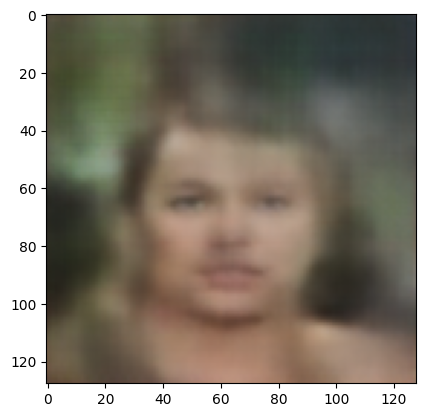

In [65]:
z = torch.randn(1, 256).to(device)
res = model.sample(z)
plt.imshow(res)